In [ ]:
# Useful Links
# 1. https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
# 2. https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/
# 3. https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0 (Understanding the resnet architecture for cifar10)


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf

In [12]:
# Load necessary libraries
import os
import pandas as pd
import numpy as np
#import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
#from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model




In [13]:
def load_dataset(dName="CIFAR10"):
    dataset = None
    num_classes = None
    if dName == "CIFAR10":
        num_classes = 10
        dataset = tf.keras.datasets.cifar10.load_data()
    if dName == "CIFAR100":
        num_classes = 100
        dataset = tf.keras.datasets.cifar100.load_data()
    (X_train, y_train), (X_test, y_test) = dataset
    # Convert target value to categorical values
    # One-hot-encoded target values
    y_train = to_categorical(y_train,num_classes)
    y_test = to_categorical(y_test, num_classes)
    
    return (X_train, y_train),(X_test, y_test)

In [15]:
def divideDataset(X_train, y_train, X_test,y_test):
    dataLength = X_train.shape[0]
    trainLen=0
    dataTrain = []
    dataTest = []
    percent = 0.2
    while(trainLen<dataLength):
        trainLen = int(X_train.shape[0]*percent)
        print(X_train[:trainLen].shape)
        train = (X_train[:trainLen],y_train[:trainLen])
        retriveLen = int(X_test.shape[0]*percent)
        test = (X_test[:retriveLen],y_test[:retriveLen])
        #print(tuple(train))
        dataTrain.append(train)
        dataTest.append(test)
        print("\n")
        percent +=0.2
    return dataTrain, dataTest

In [16]:
(X_train, y_train),(X_test, y_test) = load_dataset('CIFAR100')
dataTrain, dataTest = divideDataset(X_train, y_train, X_test, y_test) # this contains the list of 5 different datasets

(10000, 32, 32, 3)


(20000, 32, 32, 3)


(30000, 32, 32, 3)


(40000, 32, 32, 3)


(50000, 32, 32, 3)




In [17]:
def describeDataset(X_train, y_train, X_test, y_test):
    print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
    print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

In [18]:
def displayImage(images=None):
    if images.any():
        # Plot a few images
        for i in range(9):
            plt.subplot(330+1+i)
            plt.imshow(images[i])
        plt.show()
    else:
        print('Error! File is empty')

In [19]:
def normalizeInput(X_train,X_test):
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    mean = np.mean(X_train, axis=(0,1,2,3))
    std = np.std(X_train,axis=(0,1,2,3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    
    return X_train, X_test

In [20]:
# plot diagnostic learning curves
def plotLearningCurve(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.show()
    plt.close()

In [21]:
(X_train, y_train),(X_test, y_test) = load_dataset('CIFAR100')
describeDataset(X_train,y_train,X_test,y_test)

Train: X=(50000, 32, 32, 3), y=(50000, 100)
Test: X=(10000, 32, 32, 3), y=(10000, 100)


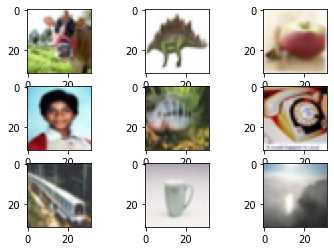

In [22]:
displayImage(X_train) # Need to pass a numpy array

In [23]:
##### Include Little Data Augmentation 
batch_size = 64 # try several values

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(X_train, y_train, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(X_test, y_test, batch_size=batch_size) # so as valid_lab

In [24]:
X_train, X_test = normalizeInput(dataTrain[0][0], dataTest[0][0])
y_train = dataTrain[0][1]
y_test = dataTest[0][1]

In [25]:
# define cnn model
def defineModel():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
#model = defineModel()
#history = model.fit(X_train,y_train,epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2)

In [ ]:
#plotLearningCurve(history)

# ResNet Implementation

In [1]:
# Code Link: https://github.com/Gurupradeep/CIFAR-10-Object-Recognition-in-Images/blob/master/Models/ResNet.ipynb

In [26]:
"""
Initial Convolutional layer which is common to all ResNet models.
"""
#Input : Input tensor
#filter : No of Convolutional filters
#stride : stride length 
#kernel_size : Convolutional filter size

#NOTE : kernel size and stride length are 7 and 2 in resnet paper

# Kernel size of 3 and stride length of 2 and 1 are tried for CIFAR-10 dataset because of low resolution of the images

def initial_conv(Input, filters, stride = 1,kernel_size = 7):
    
    x = Conv2D(filters, kernel_size=(kernel_size,kernel_size), strides = (stride,stride), padding = "same")(Input)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    return x

In [27]:
"""
Residual Block with projection shortcut to match the dimensions using 1*1 convolutions.

Note : This is basic residual Block, here all the convolutions are of same size and the depth is kept constant

"""

# Input : Input tensor
# filters : No of Filters
# Stride : stride length 
# Note : Stride 2 is used to downsample the image in CONV2,CONV3 and CONV4 blocks
# Dropout : Adds Dropout layer if dropout is greater than 0

def expand_conv_basic_block(Input, filters, stride=1, dropout = 0.0):
    Init = Input
    
    #First conv which is used to downsample the image
    x = Conv2D(filters,kernel_size=(3,3),strides = (stride,stride),padding = "same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Optional Dropout layer
    if(dropout > 0.0):
        x = Dropout(dropout)(x)
    
    x = Conv2D(filters,kernel_size=(3,3),strides = (1,1),padding = "same")(x)
    x = BatchNormalization()(x)
    
    #Projection shortcut to make skip connection(Paper terminology)
    skip_conv = Conv2D(filters, kernel_size = (1,1),strides = (stride,stride),padding = "same")(Input)
    skip = BatchNormalization()(skip_conv)
    
    #Skip connection
    x = Add()([x,skip])
    return x

In [28]:
"""
Residual networks with basic Identity shortcuts

"""
# Input : Input tensor
# filters : No of Filters
# Stride : stride length 
# Dropout : Adds Dropout layer if dropout is greater than 0

def normal_conv_basic_block(Input, filters, stride = 1, dropout = 0.0):
    
    x = Conv2D(filters,kernel_size=(3,3),strides = (stride,stride),padding = "same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Optional Dropout layer
    if(dropout > 0.0):
        x = Dropout(dropout)(x)
    
    x = Conv2D(filters,kernel_size=(3,3),strides = (stride,stride),padding = "same")(x)
    x = BatchNormalization()(x)
    
    #Identity skip connection
    x = Add()([x,Input])
    
    return x

In [29]:
"""
Residual Block with projection shortcut to match the dimensions using 1*1 convolutions.

Note : This is bottleneck residual block. Here first 1*1 convolution is used to reduce depth, followed by 3*3 
        and last 1*1 is used to restore the depth

"""

# Input : Input tensor
# filters : No of Filters
# Stride : stride length 
# Note : Stride 2 is used to downsample the image in CONV2,CONV3 and CONV4 blocks
# Dropout : Adds Dropout layer if dropout is greater than 0

def expand_conv_bottleneck_block(Input,filters,stride=1,dropout = 0.0):
    
    #Contracting 1*1 conv
    x = Conv2D(filters,kernel_size=(1,1),strides = (stride,stride),padding = "same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #if(dropout > 0.0):
     #   x = Dropout(dropout)(x)
    
    #Depth preserving 3*3 conv
    x = Conv2D(filters,kernel_size=(3,3),strides = (1,1),padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #if(Dropout > 0.0):
     #   x = Dropout(dropout)(x)
    
    #Expanding 1*1 Conv
    x = Conv2D(filters*4,kernel_size=(1,1),strides = (1,1),padding = "same")(x)
    x = BatchNormalization()(x)
    
    #Projection shortcut
    skip_conv = Conv2D(filters*4,kernel_size = (1,1), strides = (stride, stride),padding = "same")(Input)
    skip = BatchNormalization()(skip_conv)
    
    #Skip connection
    x = Add()([x,skip])
    
    return x

In [6]:
"""
Residual networks with bottleneck Identity shortcuts

"""
# Input : Input tensor
# filters : No of Filters
# Stride : stride length 
# Dropout : Adds Dropout layer if dropout is greater than 0


def normal_conv_bottleneck_block(Input, filters, stride = 1, dropout = 0.0):
    #Contracting 1*1 conv
    x = Conv2D(filters,kernel_size=(1,1),strides = (stride,stride),padding = "same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #if(dropout > 0.0):
     #   x = Dropout(dropout)(x)
        
    #Depth preserving 3*3 Conv
    x = Conv2D(filters,kernel_size=(3,3),strides = (stride,stride),padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
   # if(Dropout > 0.0):
    #    x = Dropout(dropout)(x)
    
    #Expanding 1*1 Conv
    x = Conv2D(filters*4,kernel_size=(1,1),strides = (stride,stride),padding = "same")(x)
    x = BatchNormalization()(x)
    
    #Identity skip connection
    x = Add()([x,Input])
    
    return x

In [7]:
"""
Helper function to Build ResNet using basic residual blocks.
Used when the total no of layers are less than 50.

"""
#h = height of the image
#w = width of the image
#no_of_outputs = no of classification classes
#r1 = No of times first conv block should be repeated
#r2 = No of times second conv block should be repeated
#r3 = No of times third conv block should be repeated
#r4 = No of times fourth conv block should be repeated

# first_conv_stride = stride which will be used for initial conv block
# first_max_pool = boolean to decide to apply max pooling or not
# first_conv_size = kernel size which will be used for initial conv block

#NOTE : The above three parameters are used only for cifar 10 data set coz of it's low resolution. 
        #For ImageNet Dataset they can be left as default


def build_basic_resnet(h, w, no_of_outputs, r1,r2,r3,r4, first_conv_stride = 2, first_max_pool = True,first_conv_kernel_size = 7):
    
    #Creating input tensor
    inputs = Input(shape = (h,w,3), name = "image_input")
    
    # Inital Conv block
    x = initial_conv(inputs,64,first_conv_stride,first_conv_kernel_size)
    
    #Optional Max pooling layer
    if(first_max_pool):
        x = MaxPooling2D(pool_size=(2,2))(x)
    

    #Expanding block1 with projection shortcut
    x = expand_conv_basic_block(x,64,1)
    x = Activation('relu')(x)
    
    #Repeating block of Conv1
    for i in range(r1-1):
        x = normal_conv_basic_block(x,64)
        x = Activation('relu')(x)
    
    #Expanding block2 with projection shortcut
    x = expand_conv_basic_block(x,128,2)
    x = Activation('relu')(x)
    
    #Repeating block of Conv2
    for i in range(r2-1):
        x = normal_conv_basic_block(x,128)
        x = Activation('relu')(x)
    
    #Expanding block3 with projection shortcut
    x = expand_conv_basic_block(x,256,2)
    x = Activation('relu')(x)
    
    #Repeating block of Conv3
    for i in range(r3-1):
        x = normal_conv_basic_block(x,256)
        x = Activation('relu')(x)
          
     #Expanding block4 with projection shortcut
    x = expand_conv_basic_block(x,512,2)
    x = Activation('relu')(x)
    
    #Repeating block of Conv3
    for i in range(r4-1):
        x = normal_conv_basic_block(x,512)
        x = Activation('relu')(x)
    
    shape = K.int_shape(x)
    
    #Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                                 strides=(1, 1))(x)
   # x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    
    #Classifier Block
    x = Dense(no_of_outputs,activation='softmax')(x)
    
    model = Model(inputs = inputs, outputs = x)
    return model

In [8]:
"""
Helper function to Build ResNet using bottleneck residual blocks.
Used when the total no of layers are more than 50.

"""
#h = height of the image
#w = width of the image
#no_of_outputs = no of classification classes
#r1 = No of times first conv block should be repeated
#r2 = No of times second conv block should be repeated
#r3 = No of times third conv block should be repeated
#r4 = No of times fourth conv block should be repeated

# first_conv_stride = stride which will be used for initial conv block
# first_max_pool = boolean to decide to apply max pooling or not
# first_conv_size = kernel size which will be used for initial conv block

#NOTE : The above three parameters are used only for cifar 10 data set coz of it's low resolution. 
        #For ImageNet Dataset they can be left as default


def build_bottleneck_resnet(h, w, no_of_outputs, r1,r2,r3,r4, first_conv_stride = 2, first_max_pool = True,first_conv_kernel_size = 7):
    
    #Creating input tensor
    inputs = Input(shape = (h,w,3), name = "image_input")
    
    # Inital Conv block
    x = initial_conv(inputs,64,first_conv_stride,first_conv_kernel_size)
    
    #Optional Max pooling layer
    if(first_max_pool):
        x = MaxPooling2D(pool_size=(2,2))(x)
        
    #Expanding block1 with projection shortcut
    x = expand_conv_bottleneck_block(x,64,1)
    x = Activation('relu')(x)
    
    #Repeating block of Conv1
    for i in range(r1-1):
        x = normal_conv_bottleneck_block(x,64)
        x = Activation('relu')(x)
    
    #Expanding block2 with projection shortcut
    x = expand_conv_bottleneck_block(x,128,2)
    x = Activation('relu')(x)
    
    #Repeating block of Conv2
    for i in range(r2-1):
        x = normal_conv_bottleneck_block(x,128)
        x = Activation('relu')(x)
    
    #Expanding block3 with projection shortcut
    x = expand_conv_bottleneck_block(x,256,2)
    x = Activation('relu')(x)
    
    #Repeating block of Conv3
    for i in range(r3-1):
        x = normal_conv_bottleneck_block(x,256)
        x = Activation('relu')(x)
    
    #Expanding block4 with projection shortcut
    x = expand_conv_bottleneck_block(x,512,2)
    x = Activation('relu')(x)
    
    #Repeating block of Conv4
    for i in range(r4-1):
        x = normal_conv_bottleneck_block(x,512)
        x = Activation('relu')(x)
    
    shape = K.int_shape(x)
    
    #Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                                 strides=(1, 1))(x)
   # x = GlobalAveragePooling2D()(x)

    #Classifier Block
    x = Flatten()(x)
    x = Dense(no_of_outputs,activation='softmax')(x)
    
    model = Model(inputs = inputs, outputs = x)
    return model

In [30]:

#ResNet50 with stride 1 in Initial conv Block
num_of_class = 100
model = build_bottleneck_resnet(32,32,num_of_class,3,4,6,3,1,True,7)

In [31]:

model.compile(loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.01),
        metrics=['accuracy'])

In [33]:
#model Parameters
batch_size = 512
data_augmentation = True
epochs = 100
num_of_class = 100

In [ ]:
for i in range(4):
  for j in range(5):
    model = build_bottleneck_resnet(32,32,num_of_class,3,4,6,3,1,True,7)
    model.compile(loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.01),
        metrics=['accuracy'])

    fileName = str(i)+'_'+str((10*(j+1)))+'k.csv'
    path = '/content/drive/MyDrive/PhD Studies/fall21/ADVML/cifar100/'+fileName
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.5e-6)
    csv_logger = CSVLogger(path)
    early_stopper = EarlyStopping(min_delta=0.001, patience=30)
    model_chekpoint = ModelCheckpoint("ResNet50_without_dropout_without_conv_without_pool.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)
    X_train, X_test = normalizeInput(dataTrain[j][0], dataTest[j][0])
    y_train = dataTrain[j][1]
    y_test = dataTest[j][1]

    if data_augmentation :
      print("-------------Using Data augmentation------------")
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          featurewise_center=False,  # set input mean to 0 over the dataset
          samplewise_center=False,  # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,  # apply ZCA whitening
          rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
          width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
          horizontal_flip=True,  # randomly flip images
          vertical_flip=False)  # randomly flip images
      
      datagen.fit(X_train)
      model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                          steps_per_epoch=X_train.shape[0] // batch_size,
                          epochs=epochs,verbose=1,validation_data=(X_test,y_test),callbacks = [lr_reducer,csv_logger])
    
    else :
        print("-----Not Using Data augmentation---------------")
        model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(X_test, y_test),
                  shuffle=True,callbacks = [csv_logger])

-------------Using Data augmentation------------
Epoch 1/100
19/19 [==============================] - 31s 466ms/step - loss: 8.5494 - accuracy: 0.0099 - val_loss: 277468162824993767424.0000 - val_accuracy: 0.0055 - lr: 0.0100
Epoch 2/100
19/19 [==============================] - 6s 291ms/step - loss: 5.1684 - accuracy: 0.0159 - val_loss: 133373439770624.0000 - val_accuracy: 0.0135 - lr: 0.0100
Epoch 3/100
19/19 [==============================] - 6s 290ms/step - loss: 4.7492 - accuracy: 0.0180 - val_loss: 146965446656.0000 - val_accuracy: 0.0135 - lr: 0.0100
Epoch 4/100
19/19 [==============================] - 6s 289ms/step - loss: 4.5830 - accuracy: 0.0207 - val_loss: 138579600.0000 - val_accuracy: 0.0135 - lr: 0.0100
Epoch 5/100
19/19 [==============================] - 6s 290ms/step - loss: 4.5171 - accuracy: 0.0240 - val_loss: 858972.6875 - val_accuracy: 0.0135 - lr: 0.0100
Epoch 6/100
19/19 [==============================] - 6s 290ms/step - loss: 4.4541 - accuracy: 0.0242 - val_loss:

In [ ]:
#Defining Callback functions which will be called by model during runtime when specified condition satisfies

#lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.5e-6)
csv_logger = CSVLogger('/content/drive/MyDrive/PhD Studies/fall21/ADVML/cifar100/ResNet50_without_dropout_without_conv_without_pool0.csv')
early_stopper = EarlyStopping(min_delta=0.001, patience=30)
model_chekpoint = ModelCheckpoint("ResNet50_without_dropout_without_conv_without_pool.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [ ]:
#model Parameters
batch_size = 64
data_augmentation = False
epochs = 2

In [ ]:
if data_augmentation :
    print("-------------Using Data augmentation------------")
     # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    datagen.fit(X_train)
    model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=epochs,verbose=1,validation_data=(X_test,y_test),callbacks = [lr_reducer,csv_logger])
    
else :
    print("-----Not Using Data augmentation---------------")
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True,callbacks = [csv_logger])

In [ ]:
import pandas as pd
df = pd.read_csv('ResNet50_without_dropout_without_conv_without_pool.csv')
df

In [ ]:
plt.plot(df['epoch'],df['loss'])
plt.plot(df['epoch'],df['val_loss'])